<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/BigDataProject/blob/main/ArimaModels_Alex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install quandl

# Reading in the Data


In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests as grangercausalitytests
import quandl
import requests
from bs4 import BeautifulSoup
import numpy as np





# reading in macro datacsv
df1 = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/Macro%20Data.csv")

df1['DATE'] = df1['DATE'].apply(lambda x: datetime.datetime.strptime(str(x), "%m/%d/%Y"))
#df1.drop(columns=["Unnamed: 7", "% Change (M/M)", "%Change (Q/Q)", "% Change (Y/Y)", "% Change Q/Q", "DATE"], inplace =True )
df1['Year'] = pd.DatetimeIndex(df1['DATE']).year
df1['Month'] = pd.DatetimeIndex(df1['DATE']).month
# truncating data to be in a 50 year window
df1 = df1[df1['Year']>= 1950]

print(df1.info())
print(df1.head())

#df1 = df1.set_index(['DATE'], drop=True)
# pmi data from quandl
quandl.ApiConfig.api_key = "FxsNx9PisEsskkErUy4k"
df2 = quandl.get("ISM/MAN_PMI")

print(df2.info())
print(df2.head())
df2.to_csv('C:')

# treasury data
# webscrape of the Treasury's web page and creating a dataframe of the daily treasury history

url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll'

r = requests.get(url)
html = r.text
soup = BeautifulSoup(html)
table = soup.find('table', {"class": "t-chart"})
rows = table.find_all('tr')
data = []
for row in rows[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

df3 = pd.DataFrame(data, columns=['Date', 'One_Mo', 'Two_Mo', 'Three_Mo', 'Six_Mo', 'One_Yr', 'Two_Yr', 'Three_Yr', 'Five_Yr', 'Seven_Yr', 'Ten_Yr', 'Twenty_Yr', 'Thirty_Yr'])

df3.replace(to_replace='N/A', value=0, inplace=True)
df3 = df3.astype({'One_Mo':'float64', 'Two_Mo':'float64', 'Three_Mo':'float64', 'Six_Mo':'float64', 'One_Yr':'float64', 'Two_Yr':'float64', 'Three_Yr':'float64', 'Five_Yr':'float64', 'Seven_Yr':'float64', 'Ten_Yr':'float64', 'Twenty_Yr':'float64', 'Thirty_Yr':'float64'})
df3['Date'] = pd.to_datetime(df3['Date'], format="%m/%d/%y")
print(df3.info())
print(df3.head())


# Transforming and Merging The Econ Data

In [3]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
df2.index.normalize

# merging pmi data to econ data
dfmain = pd.merge(df1, df2, how='left', left_on='DATE', right_on='Date')

# transformations on treasury data
df3['TwoTenSpread'] = df3['Ten_Yr'] - df3['Two_Yr']

# monthly returns from daily returns
df3['TwoTenSpreadPctChange'] = df3['TwoTenSpread'].pct_change()
df3['DateMonth'] = df3['Date'].dt.to_period("M")
df4 = df3[['DateMonth','TwoTenSpread']]
df4['TwoTenMonthlyVariance'] = df4.groupby(['DateMonth']).transform(np.std)
df4 = df4[['DateMonth', 'TwoTenMonthlyVariance']]
df4 = df4.drop_duplicates()
df4.reset_index(inplace=True,drop='index')
df4['DateMonth'] = df4['DateMonth'].astype(str)
df4['Date'] = pd.to_datetime(df4['DateMonth'])
df4.drop(columns=['DateMonth'], inplace=True)
df4.set_index('Date', drop=True, inplace=True)

# merging 2/10 to main dataframe
dfmain = pd.merge(dfmain, df4, how='left', left_on='DATE', right_index=True)
dfmain.set_index('DATE', inplace=True)

# column transformations to attempt to get stationary values
dfmain['CpiAnnualizedPct'] = ((dfmain['CPIAUCSL']/dfmain['CPIAUCSL'].shift(1))**12-1)*100 
dfmain['GdpAnnualizedPct'] = ((dfmain['Nominal GDP']/dfmain['Nominal GDP'].shift(1))**12-1)*100 
dfmain['BopPct'] = dfmain['Balance of Payments Value'].pct_change()
dfmain['InventoriesPct'] = dfmain['Total Business inventories'].pct_change()
dfmain['WtiPct'] = dfmain['WTI SPOT Price']

# dropping columns
dfmain = dfmain.drop(columns=['CPIAUCSL', 'CPI % Change (M/M)','CPI %Change (Q/Q)'
                      ,'CPI % Change (Y/Y)', 'Nominal GDP', 'Nominal% Change Q/Q'
                      ,'DXY Open', 'DXY Low', 'DXY High', 'Balance of Payments Value'
                      ,'WTI SPOT Price', 'Vix Open', 'Vix Close', 'Total Business inventories'])

print(dfmain.columns)
print(dfmain.info())

Index(['Initial Claims (Seasonally Adjusted)', 'DXY Close', 'Vix High',
       'Vix Low', 'Year', 'Month', 'PMI', 'TwoTenMonthlyVariance',
       'CpiAnnualizedPct', 'GdpAnnualizedPct', 'BopPct', 'InventoriesPct',
       'WtiPct'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 858 entries, 1950-01-01 to 2021-06-01
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Initial Claims (Seasonally Adjusted)  654 non-null    float64
 1   DXY Close                             438 non-null    float64
 2   Vix High                              438 non-null    float64
 3   Vix Low                               438 non-null    float64
 4   Year                                  858 non-null    int64  
 5   Month                                 858 non-null    int64  
 6   PMI                                   858 non-null    float64
 7   TwoTenMonthlyV

# Functions For Lagged Correlations, Augmented Dicky Fuller Test, and ARIMA Modeling

In [51]:

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

def ADFtest(dataframe, column):
  # takes in dataframe, and column name. subsets the dataframe,
  # checks for stationarity and plots series and autocorrelation in 5 year increments
  

  df = dataframe[column]
  df = df[df.notna()]
  print("ADF TEST:" + column)
  df = df.replace([np.inf, -np.inf], np.nan).dropna()
  result1 = adfuller(df)
  print('ADF Statistic: %f' % result1[0])
  print('p-value: %f' % result1[1])
  if result1[1] > 0.05:
    return print("This Series is not stable")
  else:
    fig, axis = plt.subplots(2, figsize = (9,9))
    axis[0].set_xlabel("Date")
    axis[0].set_ylabel(column)
    axis[0].set_title(column + " Over Time")
    df.plot(ax=axis[0], style='k-')
    plot_acf(df, ax=axis[1])
    axis[0].set_title(column + "Autocorrelation Plot")
    plt.show()

In [53]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
# arima forecasting function

def ARIMA_modeling_and_forecast(df, column, diff):
  # Arima Model testing, fitting, and forecast 
  # function assumes a stationary time series is introduced

  # test train split 95% through
  splitIndex =  round(len(df)*0.95)
  traindf = df.iloc[0:round(len(df)*0.95)]
  traindf = traindf.replace([np.inf, -np.inf], np.nan).dropna()
  testdf = df.iloc[round(len(df)*0.95)+1:]
  testdf = testdf.replace([np.inf, -np.inf], np.nan).dropna()
  parameters = []
  for pindex in range(3):
      for qindex in range(6):
        p = pindex + 1 
        q = qindex + 1
        try:
          Model1 = ARIMA(traindf, order = (p,diff,q)).fit()
          param = {'AR': p, 'MA': q, 'AIC':Model1.aic} 
          parameters.append(param)
        except ValueError:
          pass


      #print('AR:', p , 'MA:', q, 'AIC:', Model1.aic)

    # finding best parameters
  modelparams = pd.DataFrame(parameters)
  try:
    bestparams = modelparams[modelparams['AIC'] == modelparams['AIC'].min()]
    try:
      Fitted_model = ARIMA(traindf
                         ,order = (int(bestparams.iloc[0]['AR'])
                         ,diff
                         ,int(bestparams.iloc[0]['MA']))).fit()
      print(bestparams)
    except ValueError:
      return print("Reject Model")
  except KeyError:
    pass
  # fitting best model
  
  
  # forecasting
  predictions = list()

  # walk-forward validation
  predictions = Fitted_model.forecast(steps=len(testdf))[0]
  predictionsdf = pd.DataFrame({'Date':testdf.index,'Predictions': predictions })
  predictionsdf.set_index('Date', inplace=True)

  # evaluate forecasts
  rmse = sqrt(mean_squared_error(testdf, predictions))
  predictionsdf['Lower RSME'] = predictionsdf - rmse
  predictionsdf['Higher RSME'] = predictionsdf['Predictions'] + rmse
  print("RSME:", rmse)
  
  # plot forecasts against actual outcomes
  #lt.title('Forecast for '+ column)
  plt.plot(testdf)
  plt.fill_between(predictionsdf.index,predictionsdf['Lower RSME'], predictionsdf['Higher RSME'], color='gray', alpha=0.2)
  plt.plot(predictionsdf['Predictions'], color='red')
  plt.show()
  returndf = pd.merge(predictionsdf, testdf, how='inner', left_index=True, right_index=True)
  print("------------------------------------------------------")
  return returndf
  

# Results of Augmented Dickey Fuller tests and ARIMA Models

In [ ]:
for column in list(dfmain.columns):
   #looping through all the columns in the df
   ADFtest(dfmain, column)

# WTI is not stationary remove
dfmain.drop(columns='WtiPct', inplace=True)

Series:  Initial Claims (Seasonally Adjusted)
   AR  MA           AIC
8   3   2  13733.399067
RSME: 858540.6100229364


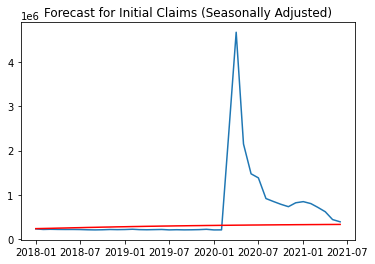

------------------------------------------------------
   AR  MA          AIC
2   2   2  13715.58645
RSME: 891935.22772104


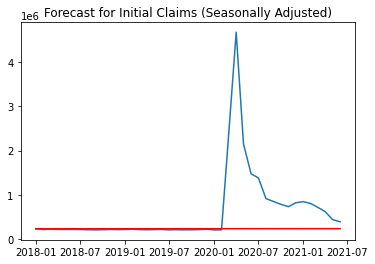

------------------------------------------------------
    AR  MA           AIC
16   3   5  13698.054651
RSME: 907198.6841157943


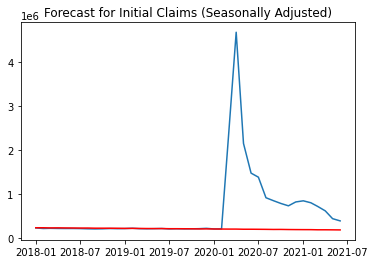

------------------------------------------------------
Series:  DXY Close
   AR  MA         AIC
1   1   2  1841.57258
RSME: 3.2737280119246965


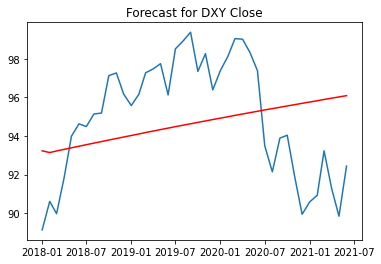

------------------------------------------------------
   AR  MA          AIC
0   2   1  1831.309863
RSME: 6.157926710703845


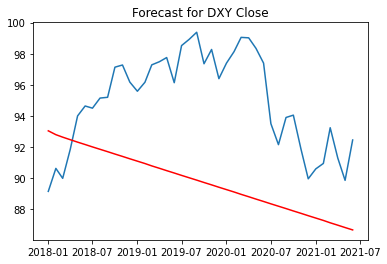

------------------------------------------------------
    AR  MA          AIC
12   3   4  1828.338706
RSME: 8.14770927822691


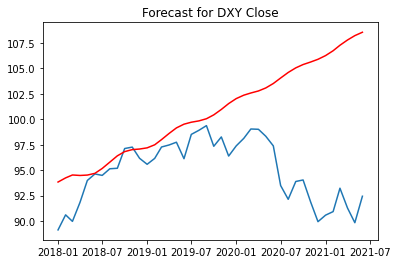

------------------------------------------------------
Series:  Vix High
   AR  MA          AIC
1   1   2  1842.574025
RSME: 3.4615024779891095


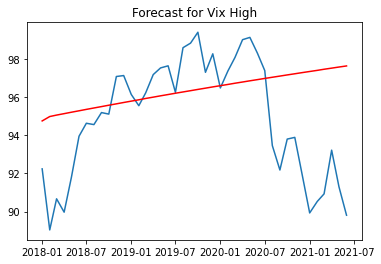

------------------------------------------------------
   AR  MA          AIC
1   2   1  1832.943936
RSME: 4.6286225184727074


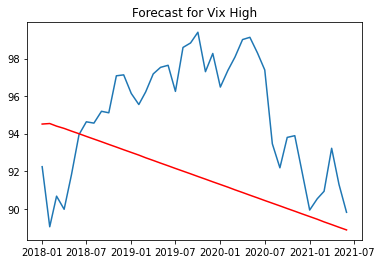

------------------------------------------------------
    AR  MA          AIC
10   2   5  1829.667763
RSME: 8.945001566023693


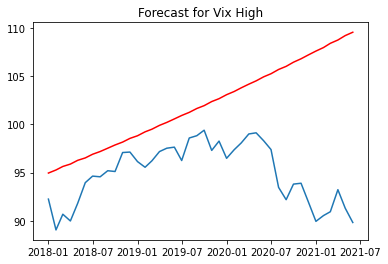

------------------------------------------------------
Series:  Vix Low
   AR  MA          AIC
3   1   4  1765.779214
RSME: 3.3583112222189198


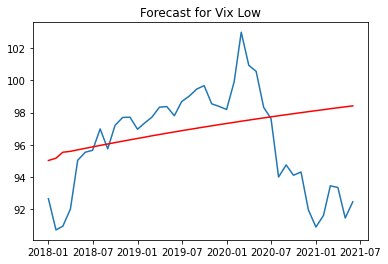

------------------------------------------------------
   AR  MA          AIC
2   2   2  1756.550086
RSME: 5.455637089805157


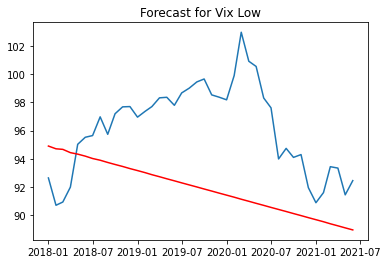

------------------------------------------------------
   AR  MA          AIC
7   2   3  1756.485566
RSME: 6.968802787203539


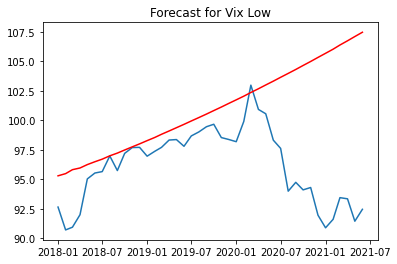

------------------------------------------------------
Series:  PMI
   AR  MA          AIC
2   1   3  3767.497624
RSME: 5.1267661963839055


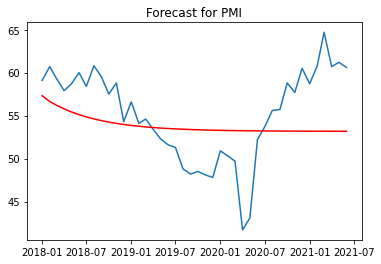

------------------------------------------------------
   AR  MA          AIC
2   1   4  3766.868583
RSME: 5.580588158162113


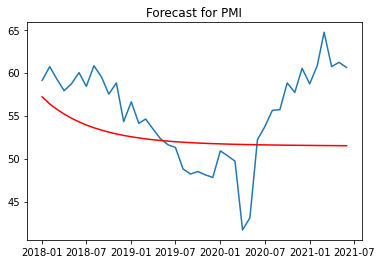

------------------------------------------------------
    AR  MA          AIC
16   3   5  3778.593061
RSME: 5.881578212259536


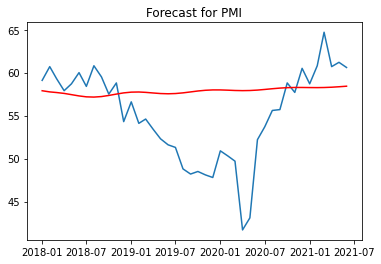

------------------------------------------------------
Series:  TwoTenMonthlyVariance
   AR  MA          AIC
5   3   2 -1175.838065
RSME: 0.031137409950835


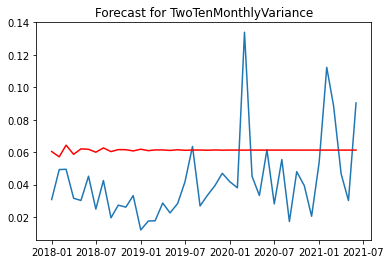

------------------------------------------------------
   AR  MA         AIC
8   2   4 -1168.83095
RSME: 0.027158560240501128


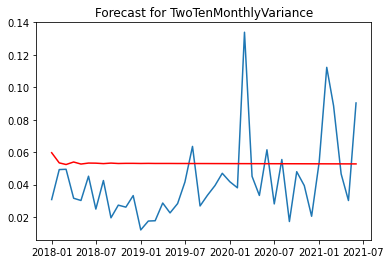

------------------------------------------------------
   AR  MA          AIC
0   1   5 -1143.785832
RSME: 0.02674432446078528


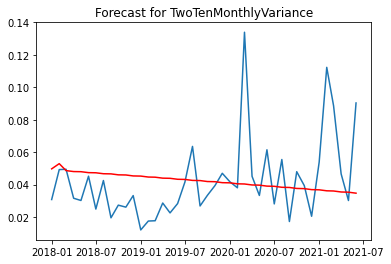

------------------------------------------------------
Series:  CpiAnnualizedPct
    AR  MA          AIC
16   3   5  4107.578187
RSME: 3.2998828278490775


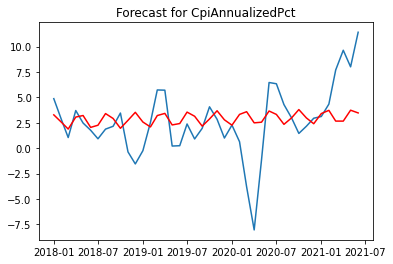

------------------------------------------------------
    AR  MA          AIC
10   2   5  4107.679546
RSME: 3.393144826338672


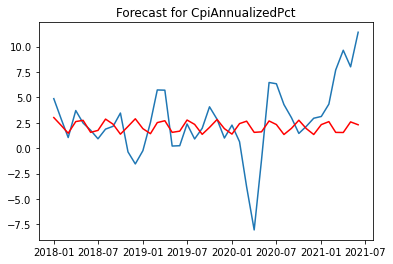

------------------------------------------------------
Series:  GdpAnnualizedPct
    AR  MA          AIC
17   3   6  5721.257162
RSME: 30.91092719575694


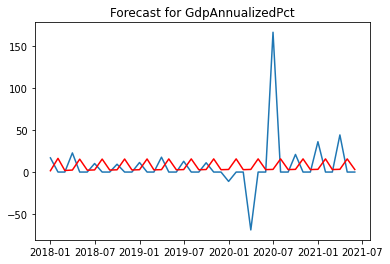

------------------------------------------------------
    AR  MA          AIC
10   2   6  5717.542991
RSME: 31.117139365867992


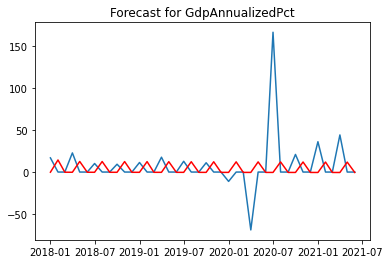

------------------------------------------------------
   AR  MA          AIC
2   2   4  5743.131084
RSME: 30.98970571627862


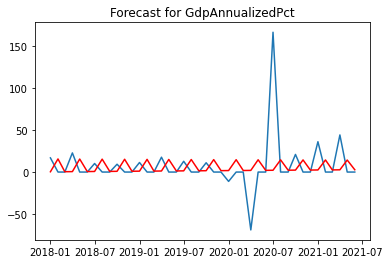

------------------------------------------------------
Series:  BopPct
   AR  MA         AIC
3   1   4 -207.221355
RSME: 0.07292133038640318


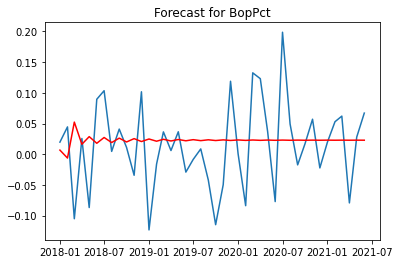

------------------------------------------------------
   AR  MA         AIC
0   1   3 -218.104466
RSME: 0.07959185360809812


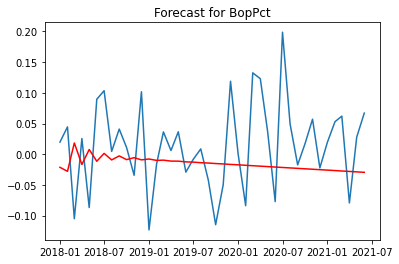

------------------------------------------------------
   AR  MA         AIC
1   1   4 -206.695176
RSME: 0.07829943187426087


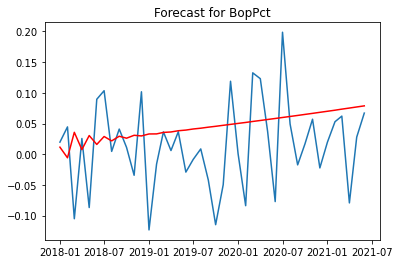

------------------------------------------------------
Series:  InventoriesPct
    AR  MA          AIC
10   3   3 -2653.874587
RSME: 0.006168561066923779


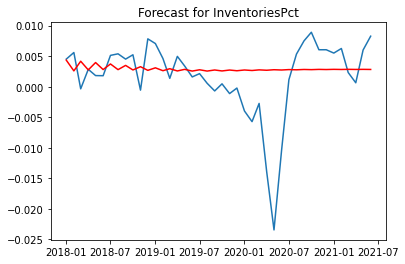

------------------------------------------------------
    AR  MA          AIC
12   3   3 -2634.497495
RSME: 0.006155102521342884


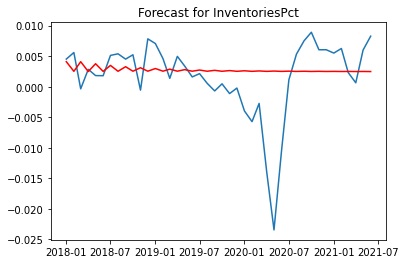

------------------------------------------------------
   AR  MA         AIC
0   1   3 -2607.18206
RSME: 0.006452361377841797


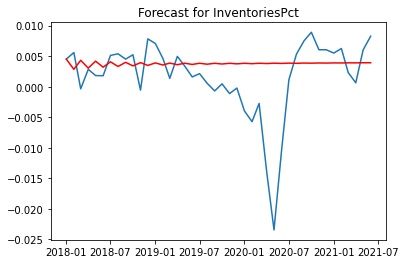

------------------------------------------------------


In [11]:
for column  in list(dfmain.columns):
  if (column == 'Year') | (column == 'Month') | (column =='WtiPct'):
    pass
  else:
    subsetdf = dfmain[column]
    print("Series: ", column)
    # looping through various differencings
    ARIMA_modeling_and_forecast(subsetdf, column, 0)
    ARIMA_modeling_and_forecast(subsetdf, column, 1)
    if column == 'CpiAnnualizedPct':
      pass
    else:
      ARIMA_modeling_and_forecast(subsetdf, column, 2)



# Correlation Analysis of Econ Data vs. Return Data

In [ ]:
index_data = pd.read_excel("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/Index%20Sectors.xlsx", skiprows=2)
index_data = index_data[0:611]
#index_data.index = pd.to_datetime(index_data['Period Ending'])+ timedelta(days=1)
##del index_data['Period Ending']
#index_data = index_data["1990-01-01":"02-01-2021"]
#index_data.head()
#print(index_data.columns)
spy = index_data[['Period Ending','S&P - 500 Index']]
spy.rename(columns={'Period Ending':'Date', 'S&P - 500 Index':'Spy'}, inplace=True)
spy['Date'] = pd.to_datetime(spy['Date'])
spy['Month'] = spy['Date'].dt.to_period("M")
spy['Year'] = spy['Date'].dt.to_period("Y")
spy.set_index('Date', drop=True, inplace=True)
print(spy.tail(20))




Series:  CpiAnnualizedPct
    AR  MA          AIC
16   3   5  4107.578187
RSME: 3.2998828278490775


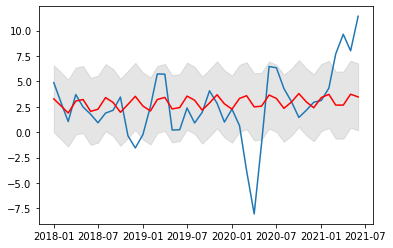

------------------------------------------------------
Lag:  0
0.12931456780592124
Lag:  1
-0.1325341710100898
Lag:  2
-0.15477398575996879
Lag:  3
-0.08426233721812054
Lag:  4
-0.14196966432310282
Lag:  5
0.09959587659305123
Lag:  6
0.12332871586404136
           Lag2        Spy
Lag2  10.360131   6.957683
Spy    6.957683  26.589169


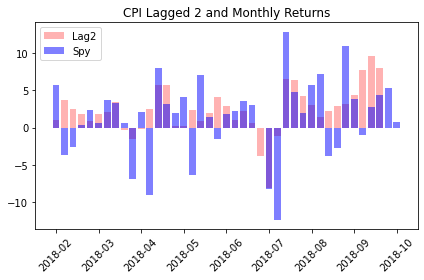

In [102]:
subsetdf = dfmain['CpiAnnualizedPct']
print("Series: ", 'CpiAnnualizedPct')
# Arima Model of CPI with no differencing
modeldf = ARIMA_modeling_and_forecast(subsetdf, 'CpiAnnualizedPct', 0)
# subset spy monthly returns to match test dataset
spy =  spy[spy['Year']>='2018']
# adding month to join on test data
modeldf['Month'] = modeldf.index.to_period("M")
comparisondf = pd.merge(modeldf, spy,how='inner', left_on='Month', right_on='Month')

# looping through lags of economic data to find the best correaltion
for i in range(7):
  print("Lag: ",i)
  print(crosscorr(comparisondf['Spy'], comparisondf['CpiAnnualizedPct'], lag=i))

comparisondf['Lag2'] =comparisondf['CpiAnnualizedPct'].shift(-2)
comparionsplotdf = comparisondf[['Lag2', 'Spy', 'Month']]
# covariance matrix of lagged data and monthly returns
print(comparionsplotdf[['Lag2', 'Spy']].cov())

# comparions plot of lagged data and monthly returns
fig, (ax) = plt.subplots(1)
ax.set_title('CPI Lagged 2 and Monthly Returns')
ax.bar(comparionsplotdf.index,comparionsplotdf['Lag2'], alpha = 0.3, color='Red', label='Lag2')
ax.bar(comparionsplotdf.index,comparionsplotdf['Spy'], alpha=0.5, color='blue', label='Spy'  )
ax.set_xticklabels(comparionsplotdf['Month'],rotation=45)
ax.legend()
fig.tight_layout()
plt.show()